In [55]:
import networkx as nx
import math
import time
import progressbar
import tqdm
import random
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool, cpu_count, Queue, Manager
%reload_ext Cython
import numpy as np

In [133]:
tree_depth = 20
log_N = 10
N = 2 ** log_N

subtree_depth = tree_depth - log_N
threshold = tree_depth

In [134]:
def generate_label(i):
    label = []
    j = 0
    l = random.randint(1, 2 ** (tree_depth + 1) - 1)
    depths[i] = int(l.bit_length() - 1)
    labels[i] = int(l)
    return label

# The first axis stores the depth of the node in the tree and the second axis stores the full label
depths = np.ndarray(shape=(N), dtype=np.uint32)
labels = np.ndarray(shape=(N), dtype=np.uint32)
for i in range(N):
    generate_label(i)

In [135]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
# --annotate
cimport numpy as np
from __main__ import threshold, tqdm, Manager, random
from __main__ import labels as labels
from __main__ import depths as depths

# __builtin_clz returns the number of leading zeros in the binary representation
cdef extern int __builtin_clz (unsigned int x)

cdef double label_distance(int first_label_index, int second_label_index,
                           unsigned int *labels, unsigned int *depths,
                           int c_threshold):
    cdef unsigned int dist = 0
    cdef unsigned int d1, l1, d2, l2, j
    cdef unsigned int height_delta
    
    if depths[second_label_index] > depths[first_label_index]:
        d1 = depths[first_label_index]
        l1 = labels[first_label_index]
        d2 = depths[second_label_index]
        l2 = labels[second_label_index]
    else:
        d1 = depths[second_label_index]
        l1 = labels[second_label_index]
        d2 = depths[first_label_index]
        l2 = labels[first_label_index]
    height_delta = d2 - d1
    l2 = l2 >> height_delta
    dist = 2 * (31 ^ __builtin_clz(((l2 ^ l1) << 1) + 1)) + height_delta
    return dist

def compute_neighborhood_of_vertex(int i):
    cdef unsigned int c_threshold = threshold
    cdef np.ndarray[unsigned int, ndim=1, mode="c"] c_labels = labels
    cdef np.ndarray[unsigned int, ndim=1, mode="c"] c_depths = depths
    cdef unsigned int *labels_ptr = &c_labels[0]
    cdef unsigned int *depths_ptr = &c_depths[0]
    cdef int num_labels = len(labels)
    cdef int j
    for j in range(i+1, num_labels):
        dist = label_distance(i, j, labels_ptr, depths_ptr, c_threshold)
        if dist < threshold:
            pass

def compute_all_neighbors(int i):
    pass

In [136]:
num_iters = N
start_time = time.time()
for i in range(num_iters):
    compute_neighborhood_of_vertex(i)
elapsed_time = time.time() - start_time
print("--- %s nanoseconds per edge ---" % (1e9 * elapsed_time / (N * num_iters)))

--- 13.983481039758772 nanoseconds per edge ---


(array([623.,   0., 840.,   0.,   0.,  68.,   0.,  12.,   0.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

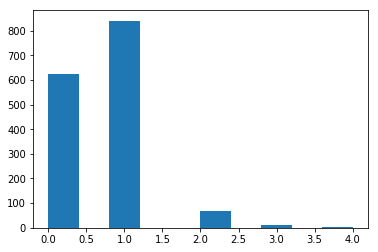

In [137]:
S = {}
current_depth = 0
while current_depth < tree_depth:
    for partial_label in range(2 ** current_depth):
        label = partial_label + 2 ** current_depth
        S[label] = []
    current_depth += subtree_depth

for label, depth in zip(labels, depths):
    extra_depth = depth % subtree_depth
    S.setdefault(label >> extra_depth, []).append(label)
plt.hist([len(values) for values in S.values()])
#[len(values) for values in S.values()]